In [37]:
!pip install tqdm
!pip install scikit-learn

You are using pip version 9.0.3, however version 23.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.3, however version 23.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


ImportError: No module named 'tensorflow'

In [38]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.svm import SVC

## Data loading

In [3]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("E:\DataChallenge\Owkin")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data_fLolZIs" / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data_fLolZIs" / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print("Training data dimensions: {}".format(df_train.shape))  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


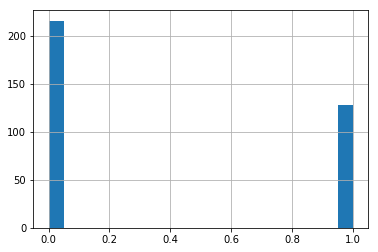

In [31]:
df_train['Target'].hist(bins=20) 
plt.show()

The datas seem pretty balanced

# Dealing with images

The following code aims to load and manipulate the images provided as part of  this challenge.

## Scanning images paths on disk

This operation can take up to 5 minutes.

In [44]:
train_images_dir = data_dir / "train_input" / "train_input" / "images"
train_images_files = list(train_images_dir.rglob("*.jpg"))

test_images_dir = data_dir / "test_input" / "test_input" / "images"
test_images_files = list(test_images_dir.rglob("*.jpg"))

print(
    "Number of images\n"
    "-----------------\n"
    "Train: {}\n" # 344 x 1000 = 344,000 tiles
    "Test: {}\n"  # 149 x 1000 = 149,000 tiles
    "Total: {}\n".format(len(train_images_files), len(test_images_files), len(train_images_files) + len(test_images_files))
)

Number of images
-----------------
Train: 344000
Test: 148999
Total: 492999



## Reading

Now we can load some of the `.jpg` images for a given sample, say `ID_001`.

In [45]:
ID_001_tiles = [p for p in train_images_files if 'ID_001' in p.name]

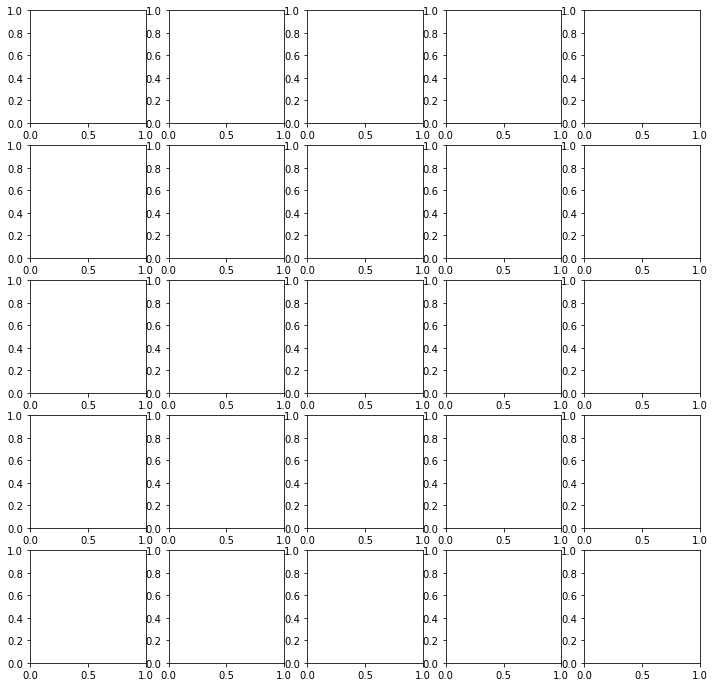

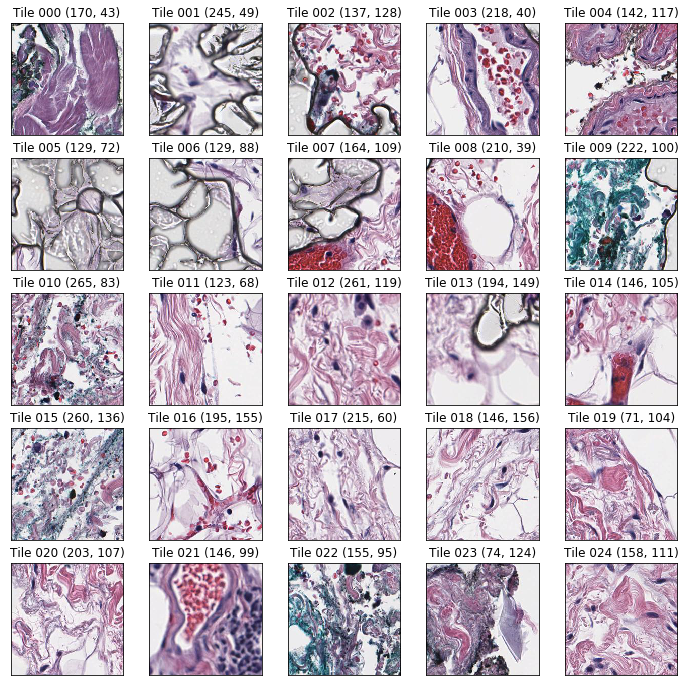

In [46]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(12, 12)

for i, img_file in enumerate(ID_001_tiles[:25]):
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    img = plt.imread(img_file)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Tile {} ({}, {})".format(id_tile, x, y))
plt.show()

## Mapping with features

Note that the coordinates in the features matrices and tiles number are aligned.

In [47]:
sample = "ID_001.npy"
_features = np.load(train_features_dir / sample)
coordinates, features = _features[:, :3], _features[:, 3:]
print("xy features coordinates")
coordinates[:10, 1:].astype(int)

xy features coordinates


array([[170,  43],
       [245,  49],
       [137, 128],
       [218,  40],
       [142, 117],
       [129,  72],
       [129,  88],
       [164, 109],
       [210,  39],
       [222, 100]])

In [48]:
print(
    "Tiles numbering and features coordinates\n"
)
[tile.name for tile in ID_001_tiles[:10]]

Tiles numbering and features coordinates



['ID_001_tile_000_17_170_43.jpg',
 'ID_001_tile_001_17_245_49.jpg',
 'ID_001_tile_002_17_137_128.jpg',
 'ID_001_tile_003_17_218_40.jpg',
 'ID_001_tile_004_17_142_117.jpg',
 'ID_001_tile_005_17_129_72.jpg',
 'ID_001_tile_006_17_129_88.jpg',
 'ID_001_tile_007_17_164_109.jpg',
 'ID_001_tile_008_17_210_39.jpg',
 'ID_001_tile_009_17_222_100.jpg']

## Data processing

We now load the features matrices $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$ for $s=1,...,344$ and perform slide-level averaging. This operation should take at most 5 minutes on your laptop.

In [4]:
X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    X_train.append(np.mean(features,axis=0))
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

100%|██████████| 344/344 [01:07<00:00,  5.10it/s]


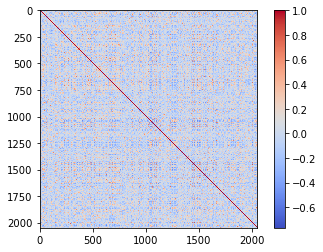

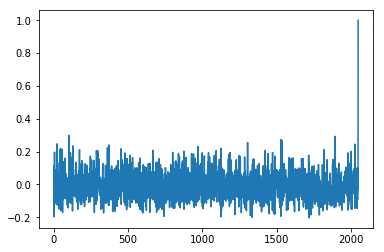

In [52]:
# Correlation matrix
X_train_label=np.insert(X_train,X_train.shape[1],y_train,axis=1)
corr_matrix=np.corrcoef(X_train_label, rowvar=False)

# Tracer la matrice de corrélation
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix, cmap="coolwarm")

# Ajouter une barre de couleur
cbar = ax.figure.colorbar(im, ax=ax)

plt.figure()
plt.plot(corr_matrix[:,-1])
# Afficher le plot
plt.show()

Idea (TO DO): Select the most relevant features from averaging and then remove averaging to have the selected sfeatures on all tiles.

Feature selection :
    - Correlation analysis: you can use the correlation matrix to identify features that have a high correlation with the target variable (if you have one). Features with a high correlation generally have more impact on the target variable.
    - Analysis of variance (ANOVA): you can use ANOVA to measure the importance of each feature by comparing the variance between groups of data. Features with higher variance are generally more important.
    - Model selection: you can use model selection algorithms such as Lasso, Ridge or Elastic Net to select the most relevant features according to their contribution to model accuracy.
    - Principal Component Analysis (PCA): you can use PCA to reduce the dimensionality of the data and identify the features that have the greatest impact on the variance of the data.
    
Test them

## 5-fold cross validation

In [35]:
# /!\ we perform splits at the patient level so that all samples from the same patient
# are found in the same split

patients_unique = np.unique(patients_train)
y_unique = np.array(
    [np.mean(y_train[patients_train == p]) for p in patients_unique]
)
centers_unique = np.array(
    [centers_train[patients_train == p][0] for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    "{} unique samples\n"
    "{} unique patients\n"
    "{} unique centers".format(len(X_train), len(patients_unique), len(np.unique(centers_unique)))
) 

Training set specifications
---------------------------
344 unique samples
305 unique patients
3 unique centers


In [40]:
aucs = []
models = []
# 5-fold CV is repeated 5 times with different random states
for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # retrieve the indexes of the samples corresponding to the
        # patients in `train_idx_` and `test_idx_`
        train_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        # set the training and validation folds
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]
        # instantiate the model
        model = RandomForestClassifier(n_estimators=200, max_depth=8)
        # fit it
        model.fit(X_fold_train, y_fold_train)
        # get the predictions (1-d probability)
        preds_val = model.predict_proba(X_fold_val)[:, 1]
        # compute the AUC score using scikit-learn
        auc = roc_auc_score(y_fold_val, preds_val)
        print("AUC on split {} fold {}: {:.3f}".format(k, fold, auc))
        aucs.append(auc)
        # add the logistic regression to the list of classifiers
        models.append(model)
        fold += 1
    print("----------------------------")
print(
    "5-fold cross-validated AUC averaged over {} repeats: {:.3f} ({:.3f})".format(k+1, np.mean(aucs), np.std(aucs))
)

AUC on split 0 fold 0: 0.658
AUC on split 0 fold 1: 0.608
AUC on split 0 fold 2: 0.734
AUC on split 0 fold 3: 0.641
AUC on split 0 fold 4: 0.780
----------------------------
AUC on split 1 fold 0: 0.722
AUC on split 1 fold 1: 0.750
AUC on split 1 fold 2: 0.683
AUC on split 1 fold 3: 0.628
AUC on split 1 fold 4: 0.758
----------------------------
AUC on split 2 fold 0: 0.606
AUC on split 2 fold 1: 0.649
AUC on split 2 fold 2: 0.780
AUC on split 2 fold 3: 0.616
AUC on split 2 fold 4: 0.593
----------------------------
AUC on split 3 fold 0: 0.711
AUC on split 3 fold 1: 0.691
AUC on split 3 fold 2: 0.616
AUC on split 3 fold 3: 0.654
AUC on split 3 fold 4: 0.634
----------------------------
AUC on split 4 fold 0: 0.648
AUC on split 4 fold 1: 0.758
AUC on split 4 fold 2: 0.691
AUC on split 4 fold 3: 0.640
AUC on split 4 fold 4: 0.574
----------------------------
5-fold cross-validated AUC averaged over 5 repeats: 0.673 (0.060)


TO DO

1. Plot validation curve to select hyperparameters
2. Plot learning curve to check bias/variance
3. Test other methods (SVM, NN)
4. Test using all selected features for each tile
5. To overcome the problems inherent in the challenge, it is necessary to limit overfitting by limiting the complexity of the model and using regularization methods



# Submission

Now we evaluate the previous models trained through cross-validation so that to produce a submission file that can directly be uploaded on the data challenge platform.

## Data processing

In [ ]:
X_test = []

# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(np.mean(features, axis=0))

X_test = np.array(X_test)

## Inference

In [ ]:
preds_test = 0
# loop over the classifiers
for model in models:
    preds_test += model.predict_proba(X_test)[:, 1]
# and take the average (ensembling technique)
preds_test = preds_test / len(models)

## Saving predictions

In [ ]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": preds_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / "benchmark_test_output.csv", index=None)
submission.head()